**Author**: Victor Teixidó López

In [ ]:
!pip install -q -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
device = 'cuda'
torch.cuda.empty_cache()

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read data from csv

We are going to read the train, validation and test data obtained in the preprocessing notebook.

In [ ]:
# Read dataframes
train_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTrainData.csv')
val_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedValidationData.csv')
test_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTestData.csv')

df = pd.concat([train_df, val_df, test_df])
df = df.reset_index(drop=True)

# Divide data

In [ ]:
# Train data definition
X_train = train_df['reviews']
y_train = train_df['ratings']

# Validation data definition
X_val = val_df['reviews']
y_val = val_df['ratings']

# Test data definition
X_test = test_df['reviews']
y_test = test_df['ratings']

# Tokenize train and validation data

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000  # maximum number of words to tokenize
seq_length = 256  # maximum length of each sequence

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['reviews'])

def tokenize_data(X_data, y_data):
  X_data = tokenizer.texts_to_sequences(X_data)
  X_data = pad_sequences(X_data, maxlen=seq_length)
  y_data= tf.keras.utils.to_categorical(y_data, 3)

  return X_data, y_data

In [ ]:
# Tokenize train data
X_train_tokenized, y_train_encoded = tokenize_data(X_train, y_train)

# Tokenize validation data
X_val_tokenized, y_val_encoded = tokenize_data(X_val, y_val)

# Neural network procedure

## Model definition

In [ ]:
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 50
lstm_units = 64
dense_units = 16

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=seq_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(dense_units, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 50)           500000    
                                                                 
 spatial_dropout1d (Spatial  (None, 256, 50)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 128)               58880     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 560995 (2.14 MB)
Trainable params: 56099

## Training

In [ ]:
batch_size = 64
epochs = 5

model.fit(X_train_tokenized, y_train_encoded,
          epochs=epochs, batch_size=batch_size,
          validation_data=(X_val_tokenized, y_val_encoded))

Epoch 1/5
1115/1115 [==============================] - 2248s 2s/step - loss: 0.5204 - accuracy: 0.7781 - val_loss: 0.4826 - val_accuracy: 0.7980
Epoch 2/5
1115/1115 [==============================] - 2193s 2s/step - loss: 0.4203 - accuracy: 0.8242 - val_loss: 0.4839 - val_accuracy: 0.8041
Epoch 3/5
1115/1115 [==============================] - 2192s 2s/step - loss: 0.3651 - accuracy: 0.8546 - val_loss: 0.4754 - val_accuracy: 0.8154
Epoch 4/5
1115/1115 [==============================] - 2186s 2s/step - loss: 0.3255 - accuracy: 0.8737 - val_loss: 0.4835 - val_accuracy: 0.8123
Epoch 5/5
1115/1115 [==============================] - 2189s 2s/step - loss: 0.2954 - accuracy: 0.8876 - val_loss: 0.5213 - val_accuracy: 0.8097


## Save the model

In [ ]:
#model.save("/content/drive/MyDrive/UNI/tfg/models/neural_network/neural_network")

# Use the trained neural network

## Tokenize test data

In [ ]:
X_test_tokenized, y_test_encoded = tokenize_data(X_test, y_test)

## Predict test data

In [ ]:
predicted_probs = model.predict(X_test_tokenized)
predicted_probs = [[round(prob, 4) for prob in pred] for pred in predicted_probs]
predicted_ratings = [np.argmax(pred) for pred in predicted_probs]

print(predicted_probs[0])
print(y_test[0], predicted_ratings[0])

585/585 [==============================] - 93s 158ms/step
[0.0143, 0.1195, 0.8662]
1 2


## Save the results into a DataFrame

In [ ]:
data = {
    'reviews': X_test,
    'ratings': y_test,
    'predicted_ratings': predicted_ratings,
    'predicted_probs': predicted_probs
}

results_df = pd.DataFrame(data)

In [ ]:
results_df.head()

,reviews,ratings,predicted_ratings,predicted_probs
0,visit disneyland many time 60 hard enjoy park ...,1,2,"[0.0143, 0.1195, 0.8662]"
1,back soon 5 day 72 mile walk 3 pound lose wait...,2,2,"[0.0056, 0.0155, 0.9789]"
2,go see harry potter world amazing fan unbeliev...,2,2,"[0.0007, 0.009, 0.9903]"
3,mean love disneylandbut unfortunately major ri...,2,2,"[0.0071, 0.1601, 0.8328]"
4,visit park 5 year ago excite rein act awesome ...,2,2,"[0.0003, 0.0134, 0.9862]"


In [ ]:
results_df.to_csv('/content/drive/MyDrive/UNI/tfg/dataframes/NeuralNetworkData.csv', index=False)

## Read results from csv (if needed)

In [ ]:
results_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/NeuralNetworkData.csv')
true_labels = results_df['ratings']
predicted_labels = results_df['predicted_ratings']
predicted_probs = results_df['predicted_probs']

# Model evaluation

We will separate our data into 3 classes from the ratings we have:
- Negative (ratings with 1/2 stars)
- Neutral (ratings with 3 stars)
- Positve (ratings with 4/5 stars)

### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


### Confusion matrix

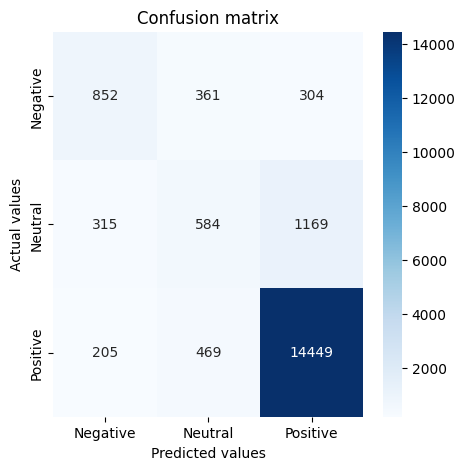

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index = ["Negative", "Neutral", "Positive"],
                              columns = ["Negative", "Neutral", "Positive"])

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix_df, cmap='Blues', annot=True, fmt='g')
plt.title("Confusion matrix")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

### Receiver Operating Characteristic (ROC) Curve

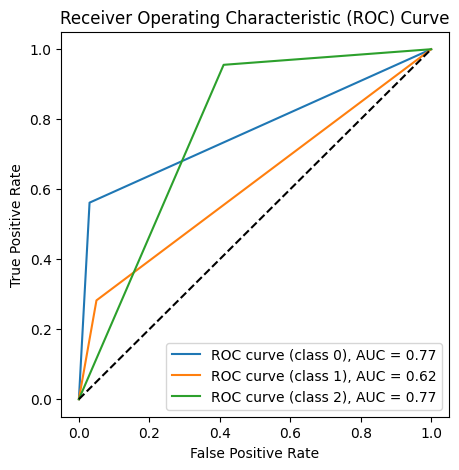


Overall AUC: 0.72


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert true and predicted labels to binary format for each class
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2])
predicted_labels_bin = label_binarize(predicted_labels, classes=[0, 1, 2])

fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(5, 5))

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve (class {i}), AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc='best')
plt.show()

# Calculate the overall AUC by averaging the AUCs of individual classes
overall_auc = sum(roc_auc.values()) / len(roc_auc)
print(f"\nOverall AUC: {overall_auc:.2f}")

### Precision, Recall and F1-score

In [ ]:
from sklearn.metrics import classification_report

class_report = classification_report(true_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"])
print(class_report)

              precision    recall  f1-score   support

    Negative       0.62      0.56      0.59      1517
     Neutral       0.41      0.28      0.34      2068
    Positive       0.91      0.96      0.93     15123

    accuracy                           0.85     18708
   macro avg       0.65      0.60      0.62     18708
weighted avg       0.83      0.85      0.84     18708

